In [1]:
import fair
fair.__version__

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 16, 5
print plt.style

<module 'matplotlib.style' from '/Users/OllieBraddy/anaconda/lib/python2.7/site-packages/matplotlib/style/__init__.pyc'>


In [2]:
# Retrieve radiative forcing data
rf_a_file = './fair/Forcing Data/rf_anthro_1750_2016.csv'
rf_n_file = './fair/Forcing Data/rf_nat_1750_2016.csv'
rf_t_file = './fair/Forcing Data/rf_total_1750_2016.csv'

rf_a_data = np.genfromtxt(rf_a_file,delimiter=',')
rf_n_data = np.genfromtxt(rf_n_file,delimiter=',')
rf_t_data = np.genfromtxt(rf_t_file,delimiter=',')

rf_t_unord = np.transpose(rf_t_data)
rf_n_unord = np.transpose(rf_n_data)
rf_a_unord = np.transpose(rf_a_data)

no_of_rf = rf_t_unord[:,0].size
length_of_rf = rf_t_unord[0].size

In [3]:
# Order rf_t values
fv = np.zeros(no_of_rf)

for x in range(0,no_of_rf):
    fv[x] = rf_t_unord[x,-1]
    
fv_sorted = np.sort(fv)

arrangement = np.zeros(no_of_rf)

for x in range(0,no_of_rf):
    arrangement[x] = fv_sorted.tolist().index(fv[x])

rf_t= np.zeros([no_of_rf,length_of_rf])

for x in range(0,no_of_rf):
    rf_t[int((arrangement[x])),:] = rf_t_unord[x,:]

In [4]:
# Calculate delta_RF value for each different RF profile
RF1870s_ave = np.zeros(no_of_rf)
RF2000s_ave = np.zeros(no_of_rf)

for x in range(0,20):
    RF1870s_ave = RF1870s_ave + rf_t[:,((length_of_rf-(2017-1860)) + x)]/20
for x in range(0,10):
    RF2000s_ave = RF2000s_ave + rf_t[:,((length_of_rf-(2017-2000)) + x)]/10

delta_RF = RF2000s_ave - RF1870s_ave

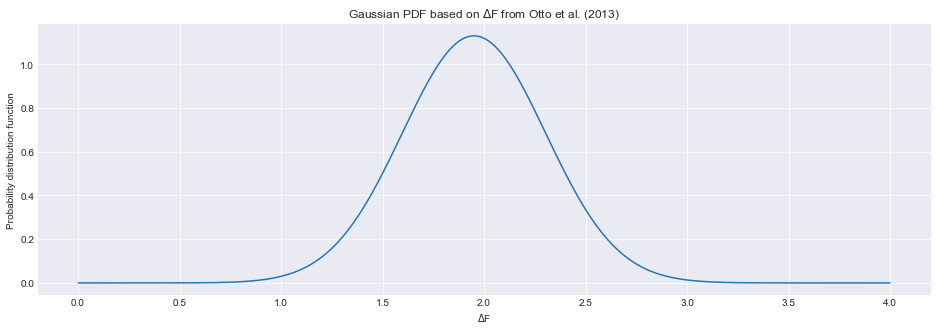

In [5]:
# Create PDF based on the delta_F values found in Otto et al. (2013)
mu_delta_F, sigma_delta_F = 1.95, 0.353
x = np.arange(0.001,4,0.001)
delta_F_pdf = (1 / (np.sqrt(2*np.pi*(sigma_delta_F**2)))) * np.exp(-(((x-mu_delta_F)**2)/(2*(sigma_delta_F**2))))

plt.rcParams['figure.figsize'] = 16, 5
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(x,delta_F_pdf)
ax1.set_ylabel('Probability distribution function')
ax1.set_xlabel('$\Delta$F')
ax1.set_title('Gaussian PDF based on $\Delta$F from Otto et al. (2013)')

In [6]:
# Create a weighting array to correspond to the probablility of each value in the 2D delta_T array above occuring
delta_F_weight = np.zeros(no_of_rf)

for i in range(0,no_of_rf):
    delta_F_weight[i] = (1 / (np.sqrt(2*np.pi*sigma_delta_F**2))) * np.exp(-(((delta_RF[i]-mu_delta_F)**2)/(2*sigma_delta_F**2)))

In [7]:
# Set emissions to zero
emissions = np.zeros(length_of_rf)

# Create TCR and ECS array
TCR = np.arange(0.5,4.5,0.02)
ECS = TCR*1.5

no_of_tcr = TCR.size

In [8]:
# Create input parameter array with above defined TCR and ECS values
input_params_in=np.array([0.33,0.41,1.6,2.75,239.0,4.1,0.2173,0.2240,0.2824,0.2763,1000000,394.4,36.54,4.304,32.40,0.019,4.165,3.74,278.0,2.123,97.0])

input_params = np.zeros([no_of_tcr,22])

for i in range(0,no_of_tcr):
    for j in range(0,21):
        input_params[i,j] = input_params_in[j]

input_params[...,2] = TCR
input_params[...,3] = ECS

In [10]:
# re_run can be set as False to just import data previously saved into a .txt file
# Create loop to run FAIR over 200 different forcing profiles imported above
re_run = False

if re_run == False:
    import time
    start_time = time.time()
    T = np.loadtxt('T_data.txt')
    T = T.reshape((no_of_rf,no_of_tcr,length_of_rf))
    print("Run time was %s seconds" % round((time.time() - start_time),2))
    
else:
    T = np.zeros([no_of_rf,no_of_tcr,length_of_rf])

    import time
    start_time = time.time()

    C,T = fair.forward.fair_scm(emissions=emissions,
                                    other_rf=rf_t,
                                    input_params=input_params)
    print("Run time was %s minutes" % round(((time.time() - start_time)/60),2))
    
    # Write the 3D array of T to disk
    with file('T_data.txt', 'w') as outfile:
        outfile.write('# Array shape: {0}\n'.format(T.shape))
        for data_slice in T:
            np.savetxt(outfile, data_slice, fmt='%-7.2f')
            outfile.write('# New slice\n')

Run time was 28.08 minutes


In [11]:
# Define delta_T as the difference between the average of the 2000s and 1870s 
# temperature anomalies as done in Otto et al. (2013)
T1870s_ave = np.zeros([no_of_rf,no_of_tcr])
T2000s_ave = np.zeros([no_of_rf,no_of_tcr])

for x in range(0,20):
    T1870s_ave = T1870s_ave + T[:,:,(length_of_rf-(2017-1860)) + x]/20
for x in range(0,10):
    T2000s_ave = T2000s_ave + T[:,:,(length_of_rf-(2017-2000)) + x]/10

delta_T = T2000s_ave - T1870s_ave

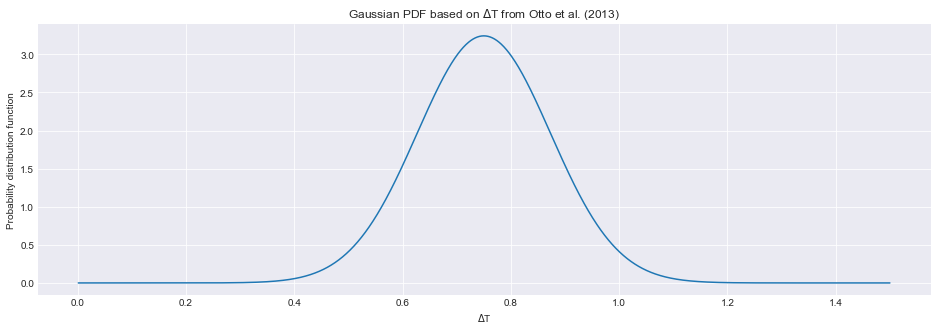

In [12]:
# Create PDF for delta_T based on Otto et al. (2013)
mu_delta_T_Oea, sigma_delta_T_Oea = 0.75, 0.123
x = np.arange(0.001,1.501,0.001)
delta_T_pdf_Oea = (1 / (np.sqrt(2*np.pi*(sigma_delta_T_Oea**2)))) * np.exp(-(((x-mu_delta_T_Oea)**2)/(2*(sigma_delta_T_Oea**2))))

plt.rcParams['figure.figsize'] = 16, 5
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(x,delta_T_pdf_Oea)
ax1.set_ylabel('Probability distribution function')
ax1.set_xlabel('$\Delta$T')
ax1.set_title('Gaussian PDF based on $\Delta$T from Otto et al. (2013)')

In [13]:
# Create a weighting array to correspond to the probablility of each value in the 2D delta_T array above occuring
# according to Otto et al. (2013)
delta_T_weight_Oea = np.zeros([no_of_rf,no_of_tcr])

for i in range(0,no_of_tcr):
    delta_T_weight_Oea[:,i] = (1 / (np.sqrt(2*np.pi*sigma_delta_T_Oea**2))) * np.exp(-(((delta_T[:,i]-mu_delta_T_Oea)**2)/(2*sigma_delta_T_Oea**2)))

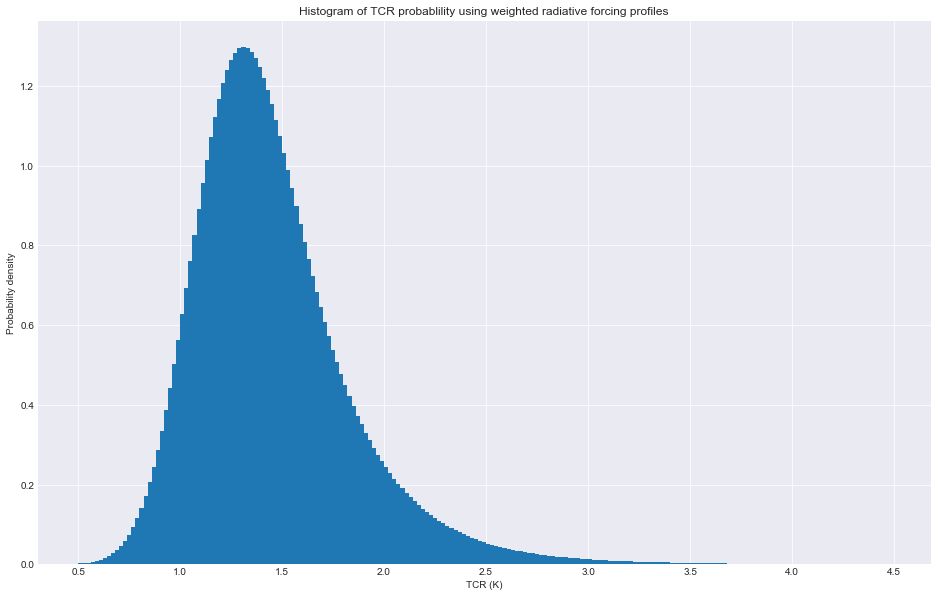

In [14]:
# Add all of the TCR histograms from each different RF profile (assuming above distribution of delta_RF as given 
# in Otto et al.).
TCR_list = TCR.tolist()
TCR_tot = np.zeros(no_of_tcr)

for x in range(0,no_of_rf):
    TCR_tot = TCR_tot + (delta_T_weight_Oea[x,:]*delta_F_weight[x])

TCR_tot = TCR_tot / (np.sum(TCR_tot)*0.02)

plt.rcParams['figure.figsize'] = 16, 10
fig = plt.figure()
ax1 = fig.add_subplot(111)

f = ax1.hist(TCR_list, weights = TCR_tot.tolist(), bins = TCR_list)

ax1.set_ylabel('Probability density')
ax1.set_xlabel('TCR (K)')
ax1.set_title('Histogram of TCR probablility using weighted radiative forcing profiles')

#fig.savefig('TCR histogram.pdf')

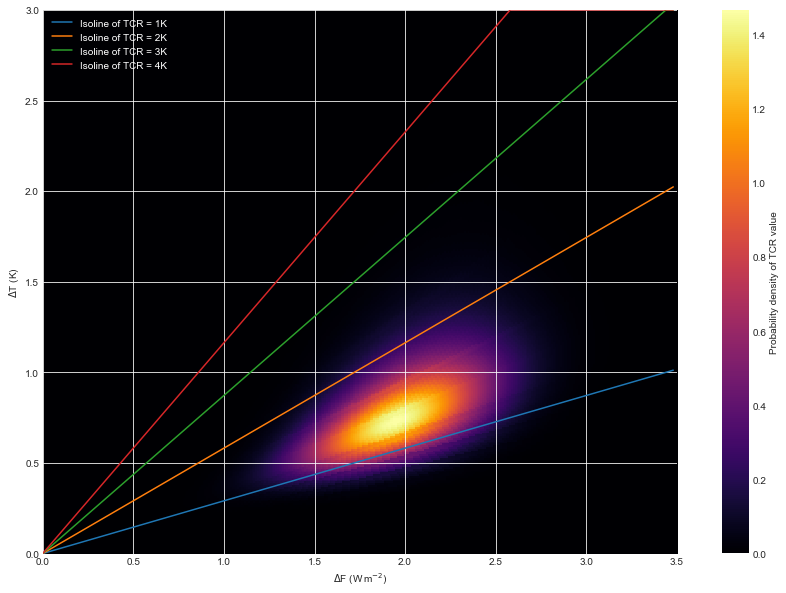

In [15]:
# Plot 

from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

def my_round(x):
    return round(x*50)/50

x = arange(0.01,3.51,0.01)
y = arange(0.01,3.01,0.01)
X,Y = meshgrid(x, y) # grid of point
k = Y/X

K = np.zeros([k[:,0].size,k[0,:].size])
for i in range(0,k[:,0].size):
    for j in range(0,k[0,:].size):
        if round((my_round(3.44*k[i,j])-0.5)*50) > 199:
            K[i,j] = 0
        elif round((my_round(3.44*k[i,j])-0.5)*50) < 0:
            K[i,j] = 0
        else:
            K[i,j] = TCR_tot[int((my_round(3.44*k[i,j])-0.5)*50)]

Z = K*((1 / (np.sqrt(2*np.pi*sigma_delta_F**2))) * np.exp(-(((X-mu_delta_F)**2)/(2*sigma_delta_F**2))))

fig = plt.figure()
ax1 = fig.add_subplot(111)
im = plt.imshow(Z,cmap=cm.inferno,origin='lower',extent=(0, max(x), 0, max(y)))

x = np.arange(0,3.5,0.02)
y = np.zeros([4,x.size])
for i in range(0,4):
    y[i] = (i+1)*x/3.44
    for j in range(0,x.size):
        if y[i,j] >= 3:
            y[i,j] = 3
        
    plt.plot(x,y[i],label='Isoline of TCR = %sK' % (i+1))

ax1.set_ylabel('$\Delta$T (K)')
ax1.set_xlabel('$\Delta$F (W$\,$m$^{-2}$)')
ax1.legend()
plt.colorbar(im).set_label('Probability density of TCR value')

leg = plt.legend(framealpha = 0, loc = 'best')
for text in leg.get_texts():
    plt.setp(text, color = 'white')
    
#fig.savefig('TCR 2D distribution.pdf')

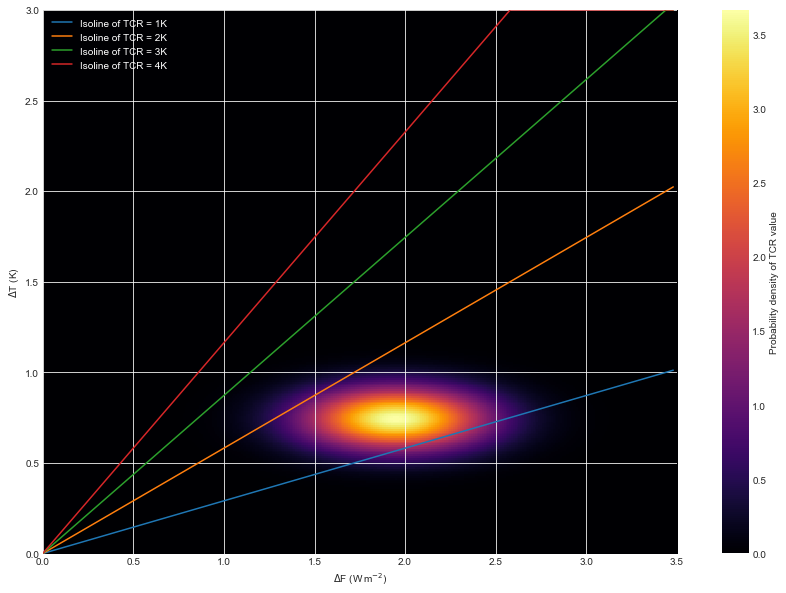

In [16]:
x = arange(0.01,3.51,0.01)
y = arange(0.01,3.01,0.01)
X,Y = meshgrid(x, y) # grid of point

Z = (1 / (np.sqrt(2*np.pi*(sigma_delta_T_Oea**2)))) * np.exp(-(((Y-mu_delta_T_Oea)**2)/(2*(sigma_delta_T_Oea**2))))*((1 / (np.sqrt(2*np.pi*sigma_delta_F**2))) * np.exp(-(((X-mu_delta_F)**2)/(2*sigma_delta_F**2))))

fig = plt.figure()
ax1 = fig.add_subplot(111)
im = plt.imshow(Z,cmap=cm.inferno,origin='lower',extent=(0, max(x), 0, max(y)))

x = np.arange(0,3.5,0.02)
y = np.zeros([4,x.size])
for i in range(0,4):
    y[i] = (i+1)*x/3.44
    for j in range(0,x.size):
        if y[i,j] >= 3:
            y[i,j] = 3
        
    plt.plot(x,y[i],label='Isoline of TCR = %sK' % (i+1))

ax1.set_ylabel('$\Delta$T (K)')
ax1.set_xlabel('$\Delta$F (W$\,$m$^{-2}$)')
ax1.legend()
plt.colorbar(im).set_label('Probability density of TCR value')

leg = plt.legend(framealpha = 0, loc = 'best')
for text in leg.get_texts():
    plt.setp(text, color = 'white')